In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql as sparksql
sc = spark.sparkContext

In [0]:
#for google colab only:
from google.colab import files
uploaded = files.upload() 



Saving train_2v.csv to train_2v (1).csv


In [0]:
df =spark.read.csv("train_2v.csv", header=True, mode="DROPMALFORMED",inferSchema=True)

## Data Exploration and Preprocessing
__Overview and data types__

In [0]:
df.count(), len(df.columns)

(43400, 12)

In [0]:
df.show(5)

+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|   work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|    children|         Rural|            95.12|18.0|           null|     0|
|30468|  Male|58.0|           1|            0|         Yes|     Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|     Private|         Urban|           110.89|17.6|           null|     0|
|56543|Female|70.0|           0|            0|         Yes|     Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|          No|Nev

In [0]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



**Summary Statistics**

In [0]:
df.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

In [0]:
df.schema.names

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [0]:
for c in df.schema.names:
  df.select(c).distinct().show()

**Check null values**<br>for bmi and smoking status (seen in the the data summary)

In [0]:
print("Null values in bmi: ", df.filter(df.bmi.isNull()).count())
print("Null values in smoking status: ", df.filter(df.smoking_status.isNull()).count())
print("Null values in both smoking status and bmi: ", df.filter((df.smoking_status.isNull() & df.bmi.isNull())).count())

Null values in bmi:  1462
Null values in smoking status:  13292
Null values in both smoking status and bmi:  426


In [0]:
df_filtered = df.filter(df.bmi.isNotNull())
df_filtered = df_filtered.na.fill('no info', subset=['smoking_status'])

**Value distribution for categorical attributes**

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def attribute_bar(y, z, attribute, valuelist):
  ax = plt.subplot(111)
  x = np.arange(len(valuelist))
  ax.bar(x-0.2, y, width=0.4, align='center', label="no stroke")
  ax.bar(x+0.2, z, width=0.4, align='center', label="stroke")
  plt.legend()
  plt.xlabel(attribute+" values")
  plt.ylabel("Frequency")
  ax.set_xticks(x)
  ax.set_xticklabels(valuelist)
  plt.title("Barplot of "+attribute+" for patients with and without strokes")
  for i in x:
    plt.text(x = x[i]-0.4 , y = y[i]+10, s = y[i], size = 11)
    plt.text(x = x[i]+0.1 , y = z[i]+10, s = z[i], size = 11)
  plt.show()

Smoking status

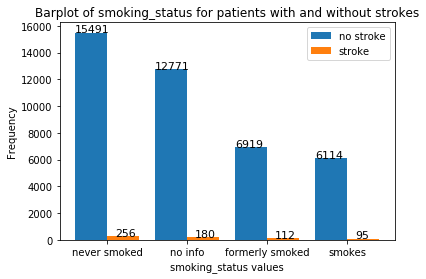

In [0]:

df_bar_0 = df_filtered.filter(df_filtered.stroke == 0).groupBy("smoking_status").count().orderBy("count", ascending=False).toPandas()
df_bar_1 = df_filtered.filter(df_filtered.stroke == 1).groupBy("smoking_status").count().orderBy("count", ascending=False).toPandas()
attribute_bar(df_bar_0["count"].tolist(), df_bar_1["count"].tolist(),
              "smoking_status", df_bar_0["smoking_status"].tolist())

In [0]:
df_filtered.groupBy("smoking_status") \
.count() \
.orderBy("count", ascending=False) \
.show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked|15747|
|        no info|12866|
|formerly smoked| 7099|
|         smokes| 6226|
+---------------+-----+



Gender

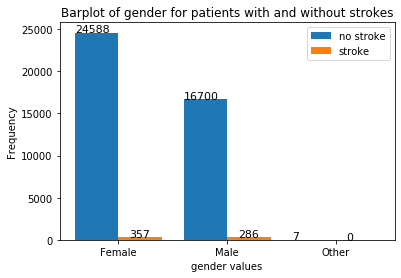

In [0]:
df_bar_0 = df_filtered.filter(df_filtered.stroke == 0).groupBy("gender").count().orderBy("count", ascending=False).toPandas()
df_bar_1 = df_filtered.filter(df_filtered.stroke == 1).groupBy("gender").count().orderBy("count", ascending=False).toPandas()
attribute_bar(df_bar_0["count"].tolist(), df_bar_1["count"].tolist() + [0], "gender", df_bar_0["gender"].tolist())

Work type

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "spark-2.4.4-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'


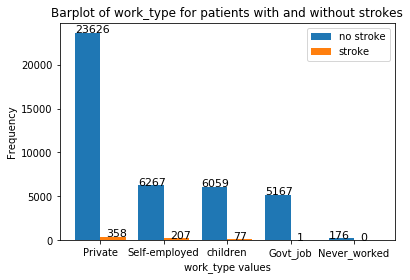

In [0]:
df_bar_0 = df_filtered.filter(df_filtered.stroke == 0).groupBy("work_type").count().orderBy("count", ascending=False).toPandas()
df_bar_1 = df_filtered.filter(df_filtered.stroke == 1).groupBy("work_type").count().orderBy("count", ascending=False).toPandas()
attribute_bar(df_bar_0["count"].tolist(), df_bar_1["count"].tolist() + [0],
              "work_type", df_bar_0["work_type"].tolist())

Marriage status

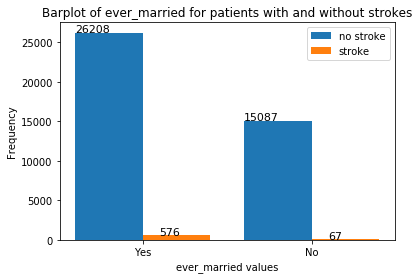

In [0]:
df_bar_0 = df_filtered.filter(df_filtered.stroke == 0).groupBy("ever_married").count().orderBy("count", ascending=False).toPandas()
df_bar_1 = df_filtered.filter(df_filtered.stroke == 1).groupBy("ever_married").count().orderBy("count", ascending=False).toPandas()
attribute_bar(df_bar_0["count"].tolist(), df_bar_1["count"].tolist(),
              "ever_married", df_bar_0["ever_married"].tolist())

Residence type

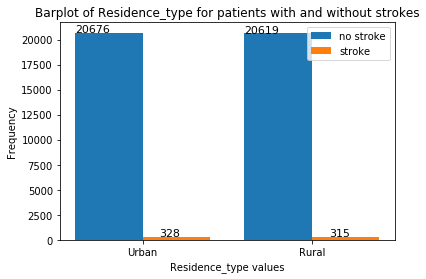

In [0]:
df_bar_0 = df_filtered.filter(df_filtered.stroke == 0).groupBy("Residence_type").count().orderBy("count", ascending=False).toPandas()
df_bar_1 = df_filtered.filter(df_filtered.stroke == 1).groupBy("Residence_type").count().orderBy("count", ascending=False).toPandas()
attribute_bar(df_bar_0["count"].tolist(), df_bar_1["count"].tolist(),
              "Residence_type", df_bar_0["Residence_type"].tolist())

**Value distribution for continuous variables**

In [0]:

def attribute_hist(a, b, attribute):
  stroke = plt.hist(a,bins=30,fc = (1,0,0,0.5),label = "stroke")
  no_stroke = plt.hist(b,bins=30,fc = (0,1,0,0.5),label = "no_stroke")
  plt.legend()
  plt.xlabel(attribute+" values")
  plt.ylabel("Frequency")
  plt.title("Histogram of "+attribute+" for patients with and without strokes")
  plt.show()
  return None

Age:

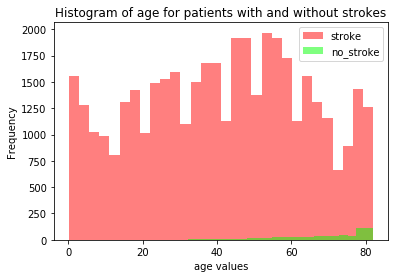

In [0]:
col_list0 = df_filtered.filter(df_filtered.stroke == 0).select("age").rdd.flatMap(lambda x: x).collect()
col_list1 = df_filtered.filter(df_filtered.stroke == 1).select("age").rdd.flatMap(lambda x: x).collect()
attribute_hist(col_list0, col_list1, "age")

Average glucose level:

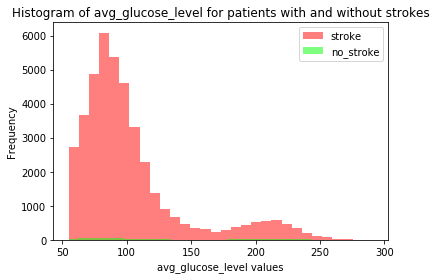

In [0]:
col_list0 = df_filtered.filter(df_filtered.stroke == 0).select("avg_glucose_level").rdd.flatMap(lambda x: x).collect()
col_list1 = df_filtered.filter(df_filtered.stroke == 1).select("avg_glucose_level").rdd.flatMap(lambda x: x).collect()
attribute_hist(col_list0, col_list1, "avg_glucose_level")

BMI:

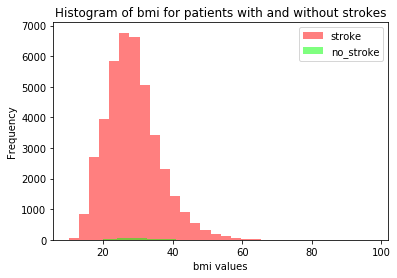

In [0]:
col_list0 = df_filtered.filter(df_filtered.stroke == 0).select("bmi").rdd.flatMap(lambda x: x).collect()
col_list1 = df_filtered.filter(df_filtered.stroke == 1).select("bmi").rdd.flatMap(lambda x: x).collect()
attribute_hist(col_list0, col_list1, "bmi")

**Outlier detection**

In [0]:
for col, dtype in df_filtered.dtypes:
  if (dtype == "int" or dtype == "double") and col not in ["id","hypertension", "heart_disease", "stroke"]: 
    q1, q3 = df_filtered.approxQuantile(col, [0.25, 0.75], 0)
    iqr = q3 - q1
    min_bound = q1 - (iqr * 1.5)
    max_bound = q3 + (iqr * 1.5)
    print("Outliers for:", col, "are outside the range of [",min_bound,",",max_bound,"]")
    df_filtered.filter(df_filtered[col] < min_bound).filter(df_filtered[col] > max_bound).select(col).show()

Outliers for: age are outside the range of [ -28.5 , 111.5 ]
+---+
|age|
+---+
+---+

Outliers for: avg_glucose_level are outside the range of [ 26.205000000000005 , 162.645 ]
+-----------------+
|avg_glucose_level|
+-----------------+
+-----------------+

Outliers for: bmi are outside the range of [ 8.65 , 47.449999999999996 ]
+---+
|bmi|
+---+
+---+



__One hot encoding__<br>
For categorical string-encoded features: gender, marriage status, work type, residence type and smoking status

In [0]:
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [0]:

from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder])
onehot_model = pipeline.fit(df_filtered)
df_onehot = onehot_model.transform(df_filtered)
# df_onehot.show(5)

**Correlation analysis**

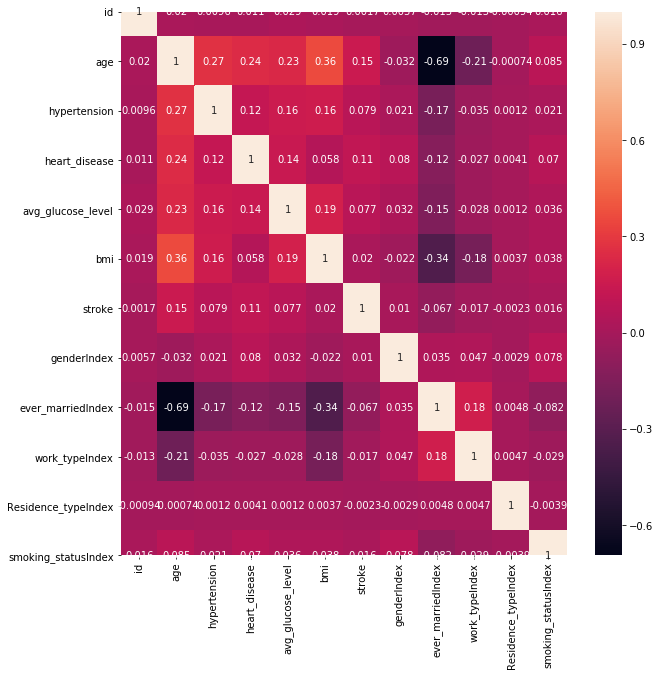

In [0]:
import seaborn as sns
import numpy as np  
corr_mat = df_onehot.select("*").toPandas().corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_mat, annot=True, ax=ax)

**Data visualization using Chernoff faces**

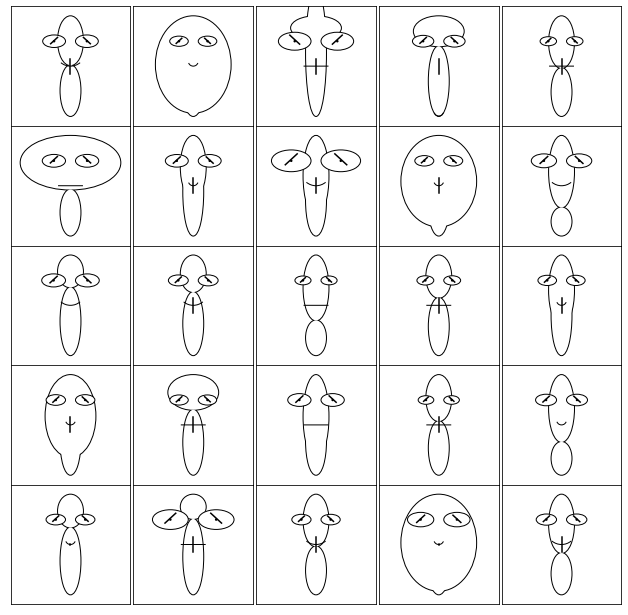

In [0]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from numpy.random import rand
from numpy import pi, arctan

def cface(ax, x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18):
    # x1 = height  of upper face, gender
    # x2 = overlap of lower face, ever_married
    # x3 = half of vertical size of face, age normalized by 100
    # x4 = width of upper face, work_type
    # x5 = width of lower face, hypertension 
    # x6 = length of nose,Residence_type
    # x7 = vertical position of mouth,  heart_disease
    # x8 = curvature of mouth, smoking_status
    # x9 = width of mouth, const
    # x10 = vertical position of eyes, const
    # x11 = separation of eyes, const
    # x12 = slant of eyes, const
    # x13 = eccentricity of eyes, const
    # x14 = size of eyes,avg_glucose_level normalized by 300 
    # x15 = position of pupils, const
    # x16 = vertical position of eyebrows, bmi normalized by 100
    # x17 = slant of eyebrows, stroke
    # x18 = size of eyebrows, const
    
    # transform some values so that input between 0,1 yields variety of output
    x3 = 1.9*(x3-.5)
    x4 = (x4+.25)
    x5 = (x5+.2)
    x6 = .3*(x6+.01)
    x8 = 5*(x8+.001)
    x11 /= 5
    x12 = 2*(x12-.5)
    x13 += .05
    x14 += .1
    x15 = .5*(x15-.5)
    x16 = .25*x16
    x17 = .5*(x17-.5)
    x18 = .5*(x18+.1)

    # top of face, in box with l=-x4, r=x4, t=x1, b=x3
    e = matplotlib.patches.Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='white', edgecolor='black', linewidth=2)
    # e.set_clip_box(ax.bbox)
    # e.set_facecolor([0,0,0])
    ax.add_artist(e)

    # bottom of face, in box with l=-x5, r=x5, b=-x1, t=x2+x3
    e = matplotlib.patches.Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='white', edgecolor='black', linewidth=2)
    ax.add_artist(e)

    # cover overlaps
    e = matplotlib.patches.Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='white', edgecolor='black', ec='none')
    ax.add_artist(e)
    e = matplotlib.patches.Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='white', edgecolor='black', ec='none')
    ax.add_artist(e)
    
    # draw nose
    ax.plot([0,0], [-x6/2, x6/2], 'k')
    
    # draw mouth
    p = matplotlib.patches.Arc( (0,-x7+.5/x8), 1/x8, 1/x8, theta1=270-180/pi*arctan(x8*x9), theta2=270+180/pi*arctan(x8*x9))
    ax.add_artist(p)
    
    # draw eyes
    p = matplotlib.patches.Ellipse( (-x11-x14/2,x10), x14, x13*x14, angle=-180/pi*x12, facecolor='white', edgecolor='black')
    ax.add_artist(p)
    
    p = matplotlib.patches.Ellipse( (x11+x14/2,x10), x14, x13*x14, angle=180/pi*x12, facecolor='white', edgecolor='black')
    ax.add_artist(p)

    # draw pupils
    p = matplotlib.patches.Ellipse( (-x11-x14/2-x15*x14/2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)
    p = matplotlib.patches.Ellipse( (x11+x14/2-x15*x14/2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)
    
    # draw eyebrows
    ax.plot([-x11-x14/2-x14*x18/2,-x11-x14/2+x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')
    ax.plot([x11+x14/2+x14*x18/2,x11+x14/2-x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')

fig = plt.figure(figsize=(11,11))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1,aspect='equal')
    sample = df_filtered.rdd.takeSample(False, 1, seed=i)[0]
    a = (0 if sample.gender=="female" else (0.5 if sample.gender=="male" else 1))
    b = (0 if sample.ever_married=="Yes" else 1)
    c = (0 if sample.work_type=="Private" else (0.25 if sample.work_type=="Self-employed" else (0.5 if sample.work_type=="children" else (0.75 if sample.work_type=="Govt_job" else 1))))
    d = (0 if sample.Residence_type=="Urban" else 1)
    e = (0 if sample.smoking_status=="never smoked" else (0.33 if sample.smoking_status=="formerly smoked" else (0.66 if sample.smoking_status=="smokes" else 1)))
    #print(sample.age,sample.avg_glucose_level,sample.bmi)
    cface(ax, a,b,(sample.age/100.0),c,sample.hypertension,d,sample.heart_disease,e,.5,.5,.5,.5,.5,(sample.avg_glucose_level/300.0),.5,(sample.bmi/100.0),sample.stroke,.5)
    ax.axis([-1.2,1.2,-1.2,1.2])
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace=0, wspace=0)


# Prediction Model: Decision Tree

**Put variables into feature column**

In [0]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

**train a decision tree model**

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

**put all steps into the pipeline**

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

**set training and testing set**

In [0]:
train_data, val_data = df_filtered.randomSplit([0.7,0.3])
model = pipeline.fit(train_data)

**evaluate the classifier with the validation set**

In [0]:
dtc_predictions = model.transform(val_data)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('The Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

The Decision Tree algorithm had an accuracy of: 98.51%


# Prediction Model: Gradient-Boost Tree

**define the Gradient-Boost Classifier**

In [0]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="stroke", featuresCol="features", maxIter=10)

**import previous indexers for categorial variables plus the classifier into a pipeline**

In [0]:
pipeline2 = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, gbt])
train_data2, val_data2 = df_filtered.randomSplit([0.7,0.3])
model2 = pipeline2.fit(train_data2)

**evaluate the classifier with the validation set**

In [0]:
gbt_predictions = model2.transform(val_data2)

In [0]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
gbt_acc = acc_evaluator.evaluate(gbt_predictions)
print('The Gradient-Boost Tree algorithm had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

The Gradient-Boost Tree algorithm had an accuracy of: 98.42%
